In [2]:
import fastf1
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import warnings
from pathlib import Path
import seaborn as sns
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime

warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.WARNING)

fastf1.Cache.enable_cache(os.getcwd())

# Window size (range of the sliding window used in delta angle calculation)
N = 15

# Max and Min delta angle for a data point to be classified as being part of a corner
CORNER_THRESHOLD = 0.4
SPEED_THRESHOLD = 200

## Load and Prepare Formula 1 Race Sessions

In [3]:
year = 2025

schedule = fastf1.get_event_schedule(year)
gp_events = schedule[schedule['EventName'].str.contains("Grand Prix")]['EventName'].tolist()
gp_events = schedule[
    (schedule['EventName'].str.contains("Grand Prix")) &
    (schedule['EventDate'] <= datetime.datetime.now())
]['EventName'].tolist()

sessions = {}

def load_session(event):
    try:
        session = fastf1.get_session(year, event, 'R')
        session.load(telemetry=True, laps=True, weather=True)
        return event, session
    except Exception as e:
        print(f"Cannot load {event}.")
        return None

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(load_session, e): e for e in gp_events}
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            event, session = result
            sessions[event] = session

core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 81 completed the race distance 00:00.036000 before the recorded end of the session.
core        WARNING 	Fixed incorrect tyre stint information for driver '81'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	

## Compute Cornering and Telemetry Metrics for Each Race

In [3]:
race_stats = pd.DataFrame()
race_data = []

for event in gp_events:
    session = sessions[event]
    try:
        telemetry = session.laps.pick_driver('VER').get_telemetry()
    except Exception as e:
        print(f"Timing data not available for {event}")
        continue
    telemetry = telemetry[['X', 'Y','Speed']]

    dx1 = telemetry['X'] - telemetry['X'].shift(N)
    dy1 = telemetry['Y'] - telemetry['Y'].shift(N)
    dx2 = telemetry['X'].shift(-N) - telemetry['X']
    dy2 = telemetry['Y'].shift(-N) - telemetry['Y']

    telemetry['Event'] = event

    telemetry['Delta_Angle'] = np.arctan2(dx1*dy2 - dy1*dx2, dx1*dx2 + dy1*dy2)
    telemetry['Delta_Angle'] = telemetry['Delta_Angle'].fillna(0)

    telemetry['IsCorner'] = ((telemetry['Delta_Angle'] > CORNER_THRESHOLD) | (telemetry['Delta_Angle'] < -CORNER_THRESHOLD) | (telemetry['Speed'] < SPEED_THRESHOLD))

    race_data.append(telemetry)

race_stats = pd.concat(race_data, ignore_index=True)
race_stats.to_csv("race_stats.csv", index=False)

## Visualize Telemetry Data and Cornering Events

In [4]:
race_stats_csv = pd.read_csv("race_stats.csv")

for event in race_stats_csv["Event"].unique():
    event_data = race_stats_csv[race_stats_csv["Event"] == event]

    plt.figure(figsize=(6.4, 4.8))
    cmap = sns.color_palette('viridis', as_cmap = True)
    norm = plt.Normalize(vmin=race_stats_csv['Delta_Angle'].min(), vmax=race_stats_csv['Delta_Angle'].max())

    sc = sns.scatterplot(data=event_data,
                        x='X', y='Y',
                        hue='Delta_Angle',
                        palette='viridis',
                        hue_norm=norm,
                        legend=False,
                        edgecolor=None)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = plt.gca())

    plt.savefig(f"{event}_deltaAngle.png")
    plt.close()

    plt.figure(figsize=(6.4, 4.8))
    sns.scatterplot(data=event_data,
                    x='X', y='Y',
                    hue='IsCorner',
                    palette={False: "blue", True: "red"},
                    edgecolor=None)

    plt.savefig(f"{event}_isCorner.png")
    plt.close()

## Extract Driver Lap Statistics and Telemetry Metrics

In [6]:
df = pd.DataFrame()
rows = []

def pick_median(laps):
    valid_laps = laps.dropna(subset=['LapTime']).reset_index(drop=True)
    if valid_laps.empty: return None
    times = valid_laps['LapTime'].dt.total_seconds()
    median_time = np.median(times)
    median_lap_index = (times - median_time).abs().argsort().iloc[0]
    return valid_laps.iloc[median_lap_index]

for event in gp_events:
    session = sessions[event]

    for num in session.drivers:
        driver = session.get_driver(num)['Abbreviation']
        team = session.get_driver(num)['TeamName']

        driver_laps_all = session.laps.pick_driver(driver)
        if driver_laps_all.empty:
            continue
        
        #TODO filter out non-representative racing laps (e.g. safety car, vsc, yellow flag, wet conditions)
        # driver_laps_race = driver_laps_all[driver_laps_all(['TrackStatus'] == '1') & (driver_laps_all['PitInTime'].isna()) & (driver_laps_all['PitOutTime'].isna())] #selects for laps done under green flag conditions, also excluding pit in and pit out laps
        
        lap_median = pick_median(driver_laps_all)
        lap_fastest = driver_laps_all.pick_fastest()
        if lap_median is None or lap_fastest is None: continue
        tel_median = lap_median.get_car_data()
        tel_fastest = lap_fastest.get_car_data()

        corner_speeds = tel_median.query('Speed < 200')['Speed']
        straight_speeds = tel_median.query('Speed >= 200')['Speed']

        rows.append(
            {
                "Driver": driver,
                "Team": team,
                "Event": event,
                "TyreCompound": lap_fastest['Compound'] if 'Compound' in lap_fastest else None,
                "Qualifying Time": lap_fastest['LapTime'].total_seconds() if lap_fastest['LapTime'] else None, 
                "Top Speed": tel_median['Speed'].max(),
                "AvgCornerSpeed": corner_speeds.mean() if not corner_speeds.empty else None,
                "AvgCornerEntrySpeed": corner_speeds.head(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgCornerExitSpeed": corner_speeds.tail(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgStraightSpeed": straight_speeds.mean()if not straight_speeds.empty else None,
                "AvgStraightEntrySpeed": straight_speeds.head(5).mean() if len(straight_speeds) >= 5 else None,
                "AvgStraightExitSpeed": straight_speeds.tail(5).mean() if len(straight_speeds) >= 5 else None,
                "ThrottleMean": tel_median['Throttle'].mean(),
                "ThrottleStdDev": tel_median['Throttle'].std(),
                "BrakeMean": tel_median['Brake'].mean(),
                "BrakeStdDev": tel_median['Brake'].std(),
                "DRSMean": tel_median['DRS'].mean()
            }
        )

        # weather = session.weather_data
        # df.at[i, 'AirTemp'] = weather['AirTemp']
        # df.at[i, 'TrackTemp'] = weather['TrackTemp']
        # df.at[i, 'Humidity'] = weather['Humidity']
        # df.at[i, 'Pressure'] = weather['Pressure']
        # df.at[i, 'Rainfall'] = weather['Rainfall']

df = pd.DataFrame(rows)

In [19]:
df.to_csv('f1.csv', index = False)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("f1.csv")
df.dropna(inplace=True)

## Assess Multicollinearity in Telemetry Features

In [12]:
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_columns.remove("Qualifying Time")

# Check VIF (Multicolinearity)
formula = f'Q("Qualifying Time") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                      variable          VIF
0                    Intercept  6290.555535
1               Q("Top Speed")     6.259482
2          Q("AvgCornerSpeed")     2.740664
3     Q("AvgCornerEntrySpeed")     1.142872
4      Q("AvgCornerExitSpeed")     1.120831
5        Q("AvgStraightSpeed")     7.061505
6   Q("AvgStraightEntrySpeed")    15.019837
7    Q("AvgStraightExitSpeed")    12.498465
8            Q("ThrottleMean")     7.137255
9          Q("ThrottleStdDev")     2.113944
10              Q("BrakeMean")    66.629779
11            Q("BrakeStdDev")    65.775044
12                Q("DRSMean")     1.810409


In [13]:
# Check VIF again (Multicolinearity)
continuous_columns.remove("BrakeStdDev")
continuous_columns.remove("AvgStraightExitSpeed")
continuous_columns.remove("AvgStraightSpeed")

formula = f'Q("Qualifying Time") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

                     variable          VIF
0                   Intercept  2529.499956
1              Q("Top Speed")     3.241166
2         Q("AvgCornerSpeed")     1.990485
3    Q("AvgCornerEntrySpeed")     1.067263
4     Q("AvgCornerExitSpeed")     1.074703
5  Q("AvgStraightEntrySpeed")     1.646552
6           Q("ThrottleMean")     5.468378
7         Q("ThrottleStdDev")     1.625838
8              Q("BrakeMean")     3.039454
9                Q("DRSMean")     1.688091


## Build and Evaluate Machine Learning Models

In [14]:
x = df.drop(columns=['Qualifying Time'])
x = pd.get_dummies(x, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
y = df[['Qualifying Time']]

df_reduced = df.drop(columns=['BrakeStdDev'])
x_reduced = df_reduced.drop(columns=['Qualifying Time'])
x_reduced = pd.get_dummies(x_reduced, columns=['Driver', 'Team', 'Event', 'TyreCompound'], drop_first=True)
y_reduced = df_reduced[['Qualifying Time']]

train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=1)

x_train, x_test, y_train, y_test = x.loc[train_idx], x.loc[test_idx], y.loc[train_idx], y.loc[test_idx]
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = x_reduced.loc[train_idx], x_reduced.loc[test_idx], y_reduced.loc[train_idx], y_reduced.loc[test_idx]

### Linear Regression

In [69]:
model_lm = LinearRegression()
model_lm.fit(x_train_reduced, y_train_reduced)

y_pred_lm = model_lm.predict(x_test_reduced)

r2_lm = r2_score(y_test_reduced, y_pred_lm)
rmse_lm = root_mean_squared_error(y_test_reduced, y_pred_lm)

print(f"R-Squared: {r2_lm}")
print(f"RMSE: {rmse_lm}")

R-Squared: 0.984387436064165
RMSE: 1.3543820054420703


### Random Forest Regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=1)

param_grid = {'n_estimators': list(range(1, 51)),
              'min_samples_leaf': list(range(1, 5))
              }

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

grid_search_rf.fit(x_train, y_train)

print("Best params:", grid_search_rf.best_params_)
# print("Train RMSE:", -grid_search.best_score_)

best_rf = grid_search_rf.best_estimator_

y_pred = best_rf.predict(x_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Test R-Squared: {r2}")
print(f"Test RMSE: {rmse}")

# importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
# importances.sort_values().plot(kind='barh')
# plt.show()

Best params: {'min_samples_leaf': 2, 'n_estimators': 43}
Test R-Squared: 0.9653440774826286
Test RMSE: 2.0178681805485605


### XGBoost Regressor

In [66]:
import xgboost as xgb

xg = xgb.XGBRegressor(random_state=1)

param_grid = {"n_estimators": [350, 375, 400],
              "learning_rate": [0.01, 0.05, 0.1]
              }

grid_search_xgb = GridSearchCV(
    estimator=xg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

grid_search_xgb.fit(x_train, y_train)

print("Best params:", grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_

y_pred = grid_search_xgb.predict(x_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R-Squared: {r2}")
print(f"RMSE: {rmse}")

# importances = pd.Series(best_xgb.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
# importances.sort_values().plot(kind='barh')
# plt.show()

Best params: {'learning_rate': 0.05, 'n_estimators': 400}
R-Squared: 0.9875640869140625
RMSE: 1.208767944760905


### k-Nearest Neighbors

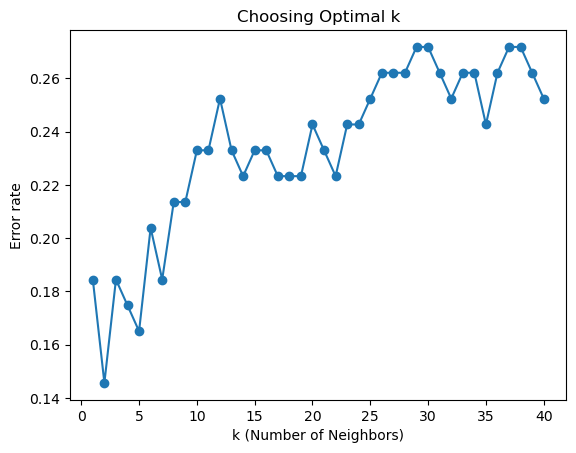

Best k: 2
Accuracy: 0.8543689320388349
                   precision    recall  f1-score   support

      Bad at both       0.93      0.90      0.91        29
     Good at both       0.70      0.84      0.76        19
  Good in corners       0.84      0.93      0.88        28
Good in straights       0.95      0.74      0.83        27

         accuracy                           0.85       103
        macro avg       0.85      0.85      0.85       103
     weighted avg       0.87      0.85      0.86       103

[[26  0  2  1]
 [ 0 16  3  0]
 [ 0  2 26  0]
 [ 2  5  0 20]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}


In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

#x-axis for kNN
x = df[['Top Speed', 'AvgCornerSpeed', 'AvgStraightSpeed', 'AvgStraightEntrySpeed', 'AvgStraightExitSpeed', 'AvgCornerEntrySpeed', 'AvgCornerExitSpeed']].values

#y-axis for kNN
labels = []
median_straight = df['AvgStraightSpeed'].median()
median_corner = df['AvgCornerSpeed'].median()
threshold = 1.01 # 1% better than others, tunable

#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
for _, row in df.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

y = labels

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.3, random_state = 1, stratify = y)

k_values = range(1, 41)   # Try k = 1 to 40
error_rate = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    error_rate.append(np.mean(predictions != y_test))

best_k = error_rate.index(min(error_rate)) + 1

plt.plot(k_values, error_rate, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Error rate")
plt.title("Choosing Optimal k")
plt.show()
print("Best k:", best_k)

#Run proper kNN
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
conmat = confusion_matrix(y_test, predictions)
print("Accuracy:", accuracy)
print(classification_report(y_test, predictions))
print(conmat)
print(knn.get_params())


### Support Vector Machine

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

#x-axis for SVM
x = df[['Top Speed', 'AvgCornerSpeed', 'AvgStraightSpeed', 'AvgStraightEntrySpeed', 'AvgStraightExitSpeed', 'AvgCornerEntrySpeed', 'AvgCornerExitSpeed']].values

#y-axis for SVM
labels = []
median_straight = df['AvgStraightSpeed'].median()
median_corner = df['AvgCornerSpeed'].median()
threshold = 1.01 # 1% better than others, tunable

#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
for _, row in df.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

y = labels

#split train and test data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.3, random_state = 1, stratify = y)

#SVM
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

      Bad at both       0.88      0.72      0.79        29
     Good at both       0.71      0.79      0.75        19
  Good in corners       0.75      0.96      0.84        28
Good in straights       0.91      0.74      0.82        27

         accuracy                           0.81       103
        macro avg       0.81      0.80      0.80       103
     weighted avg       0.82      0.81      0.80       103



### Naive Bayes Classifier

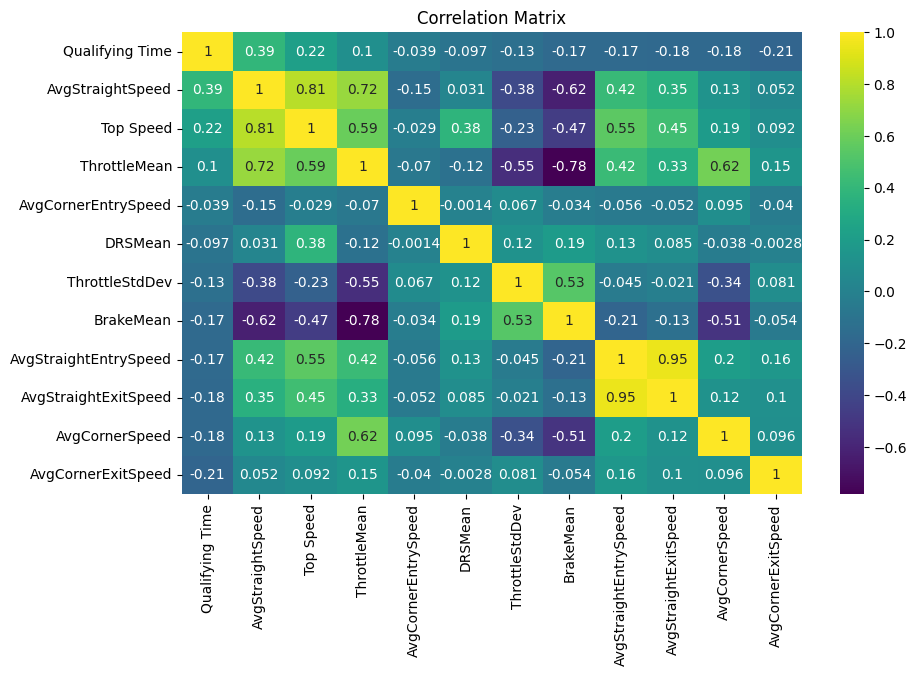

Accuracy: 0.8970588235294118


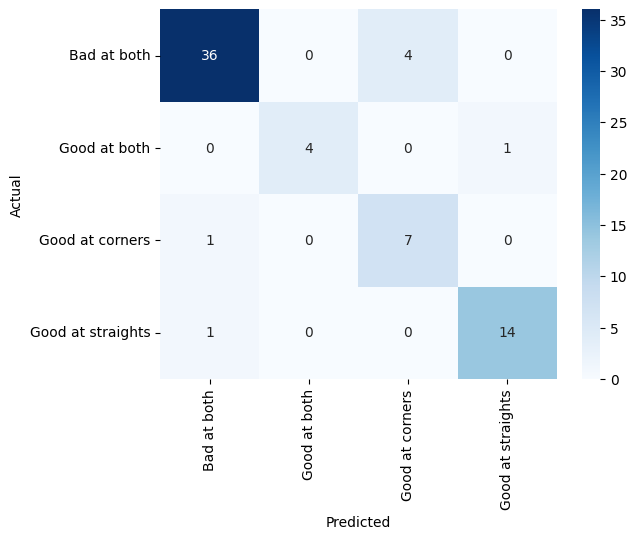

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# TODO: Move corr map to data viz section + discuss suitability of NB model

# load dataset
nb_df1 = df_reduced.loc[:,'Qualifying Time':'DRSMean']

# ---quality correlation matrix---
k = 13 # number of variables for heatmap
cols = nb_df1.corr().nlargest(k, 'Qualifying Time')['Qualifying Time'].index #change QT 
cm = nb_df1[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.title('Correlation Matrix')
plt.show()
plt.close()

# ---naive bayes classifier---
#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
def categorize_performance(row, threshold, median_corner, median_straight):
    if row['AvgCornerSpeed'] >= median_corner + threshold and row['AvgStraightSpeed'] >= median_straight + threshold:
        return 'Good at both'
    elif row['AvgCornerSpeed'] >= median_corner + threshold and row['AvgStraightSpeed'] < median_straight + threshold:
        return 'Good at corners'
    elif row['AvgCornerSpeed'] < median_corner + threshold and row['AvgStraightSpeed'] >= median_straight + threshold:
        return 'Good at straights'
    else:
        return 'Bad at both'

median_straight = df['AvgStraightSpeed'].median()
median_corner = df['AvgCornerSpeed'].median()
threshold = 5 # 1% better than others, tunable

nb_df1['PerformanceCategory'] = nb_df1.apply(categorize_performance, axis=1, threshold=threshold,
                                             median_corner=median_corner, median_straight=median_straight)

# dividing data
nb_df1_features = nb_df1.drop(['Qualifying Time', 'PerformanceCategory'], axis=1)
y = nb_df1['PerformanceCategory']

x_train, x_test, y_train, y_test = train_test_split(nb_df1_features, y, test_size=0.2, random_state=42, stratify=y)

nb = GaussianNB() 
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()
plt.close()

# thresholds = np.arange(0.5, 5.5, 0.5)
# accuracies = []
# for t in thresholds:
#     temp_df = nb_df1.copy()
#     temp_df['PerformanceCategory'] = temp_df.apply(
#         categorize_performance, axis=1, threshold=t,
#         median_corner=median_corner, median_straight=median_straight
#     )

#     X = temp_df.drop(['Qualifying Time', 'PerformanceCategory'], axis=1)
#     y = temp_df['PerformanceCategory']

#     x_train, x_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=42, stratify=y
#     )

#     nb = GaussianNB()
#     nb.fit(x_train, y_train)
#     y_pred = nb.predict(x_test)
#     acc = metrics.accuracy_score(y_test, y_pred)
#     accuracies.append(acc)

# best_threshold = thresholds[np.argmax(accuracies)]
# best_acc = max(accuracies)

# print(f"Best threshold: {best_threshold:.2f}, Accuracy: {best_acc:.3f}")
# Best threshold: 5, Accuracy: 0.8970588235294118




### K Means


Corner speed clustering
Cluster 0: RUS, VER, ANT, PIA, LEC, HAM, ALO, HUL, OCO, SAI, BEA, TSU, COL, BOR, GAS, HAD, STR, NOR, LAW, ALB
Cluster 1: ANT, HAD, BOR, PIA, NOR, LEC, VER, RUS, ALB, HAM, LAW, GAS, BEA, TSU, STR, OCO, SAI, ALO, HUL, COL
Cluster 2: NOR, VER, PIA, HAM, TSU, LAW, BOR, ALB, LEC, RUS, SAI, HAD, ALO, HUL, GAS, STR, COL, BEA, ANT, OCO
Cluster 3: GAS, PIA, NOR, RUS, VER, ALB, ANT, LEC, HAM, SAI, TSU, HAD, OCO, HUL, ALO, STR, LAW, BEA
Cluster 4: NOR, LEC, PIA, VER, HAM, HAD, OCO, LAW, ALB, SAI, RUS, BEA, COL, BOR, STR, HUL, TSU, ANT, ALO, GAS
Cluster 5: PIA, NOR, RUS, VER, OCO, ANT, ALB, BEA, STR, SAI, HAD, LAW, DOO, BOR, HUL, TSU, ALO, LEC, HAM, GAS, COL
Cluster 6: RUS, ANT, ALB, STR, HUL, LEC, GAS, OCO, BEA, ALO, VER, NOR, PIA, HAM, HAD, TSU, SAI, DOO, LAW, BOR

Corner Speed clustering RMSE: 4.969999057018318

Straight speed clustering
Cluster 0: NOR, VER, PIA, HAM, ALB, LEC, RUS, SAI, HAD, TSU, ALO, HUL, GAS, LAW, STR, COL, BEA, BOR, ANT, OCO
Cluster 1: PIA, NOR, LEC

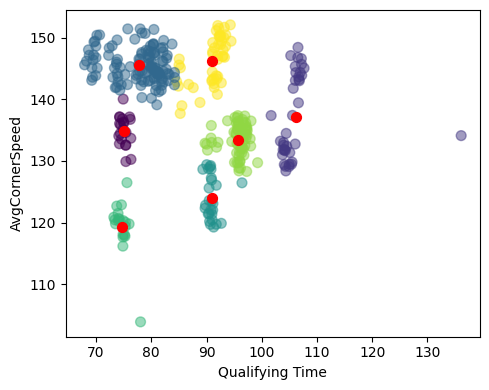

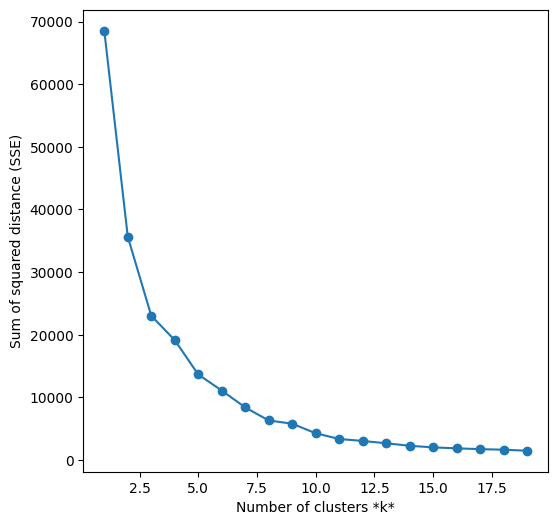

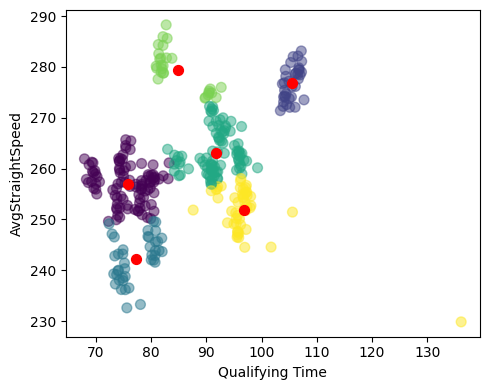

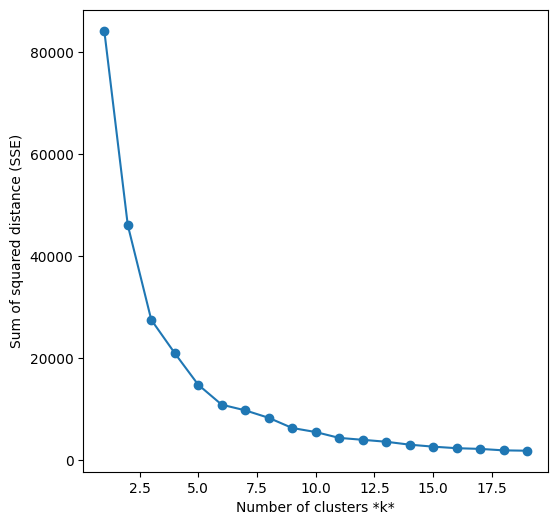

In [50]:
#k-means
from sklearn.cluster import KMeans

x = df['Qualifying Time']
hue1 = df['Driver']

# ----data exploration---
plt.figure(figsize=(10,5))
plot1 = plt.subplot(1,2,1)
sns.scatterplot(x=x, y=df['AvgCornerSpeed'], hue=hue1) #Corner speed plot
plot1.set_title('Avg Corner Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot1.text(x.iloc[i]+0.05, df['AvgCornerSpeed'].iloc[i]+0.05, driver, fontsize=7)

plot2 = plt.subplot(1,2,2)
sns.scatterplot(x=x, y=df['AvgStraightSpeed'], hue=hue1) #Straight speed plot
plot2.set_title('Avg Straight Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot2.text(x.iloc[i]+0.05, df['AvgStraightSpeed'].iloc[i]+0.05, driver, fontsize=7)

# making common legend
handles, labels = plt.gca().get_legend_handles_labels()
plot1.get_legend().remove()
plot2.get_legend().remove()
plt.legend(handles, labels, title='Driver', loc='center left', bbox_to_anchor=(1.02, 0.5),
           fontsize=7, title_fontsize=8, markerscale=0.6, frameon=False)

plt.tight_layout()
plt.close()

# ---apply k-means clustering (CORNER SPEED)---
features = ['Qualifying Time', 'AvgCornerSpeed']
X = df[features]
print()

kmeans = KMeans(n_clusters=7, random_state=0) #change n clusters here
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# --accessing corner clusters---
df['Cluster_Corner'] = kmeans.labels_
print("Corner speed clustering")
for cluster_id in sorted(df['Cluster_Corner'].unique()):
    cluster_drivers = df.loc[df['Cluster_Corner'] == cluster_id, 'Driver'].unique()
    print(f"Cluster {cluster_id}: {', '.join(cluster_drivers)}")
print()

# Compute RMSE manually
squared_errors = np.sum((X - centroids[labels])**2, axis=1)
cluster_rmse = np.sqrt(np.mean(squared_errors))
print("Corner Speed clustering RMSE:", cluster_rmse)

fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot also the training points
ax.scatter(df['Qualifying Time'], df['AvgCornerSpeed'], 
           c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
ax.set_xlabel('Qualifying Time')
ax.set_ylabel('AvgCornerSpeed')

plt.tight_layout()

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (SSE)');

optimal_k = list_k[np.argmin(sse)]
# print(f"Optimal k (Corner): {optimal_k}")

# k = 6, RMSE: 0.6524419587814484
# k = 7, RMSE: 0.46647730684291305
# k = 8, RMSE: 0.4158006395544338
# Value of k = 8 is optimal for corner speed

# ---apply k-means clustering (STRAIGHT SPEED)---
features = ['Qualifying Time', 'AvgStraightSpeed']
X = df[features]
print()

kmeans = KMeans(n_clusters=6, random_state=0) #change n cluster here
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# ---accessing straight clusters---
df['Cluster_Straight'] = kmeans.labels_
print("Straight speed clustering")
for cluster_id in sorted(df['Cluster_Straight'].unique()):
    cluster_drivers = df.loc[df['Cluster_Straight'] == cluster_id, 'Driver'].unique()
    print(f"Cluster {cluster_id}: {', '.join(cluster_drivers)}")
print()

# Compute RMSE manually
squared_errors = np.sum((X - centroids[labels])**2, axis=1)
straight_rmse = np.sqrt(np.mean(squared_errors))
print("Straight Speed RMSE:", straight_rmse)

fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot also the training points
ax.scatter(df['Qualifying Time'], df['AvgStraightSpeed'], 
           c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
ax.set_xlabel('Qualifying Time')
ax.set_ylabel('AvgStraightSpeed')

plt.tight_layout()

sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance (SSE)')

optimal_k = list_k[np.argmin(sse)]
# print(f"Optimal k (Straight): {optimal_k}")

# k = 4, RMSE: 0.7830298727862446
# k = 5, RMSE: 0.6561260588620095
# k = 6, RMSE: 0.5873858323437279
# Value of k = 6 is optimal for straight speed


### PCA

Explained variance ratio (all PCs): [0.35852579 0.20048319 0.13410943 0.1226571  0.10385573 0.05563011
 0.02010388 0.00463476]
Total variance (all PCs): 1.0000000000000002
Variance explained by PC1 and PC6: 0.4142


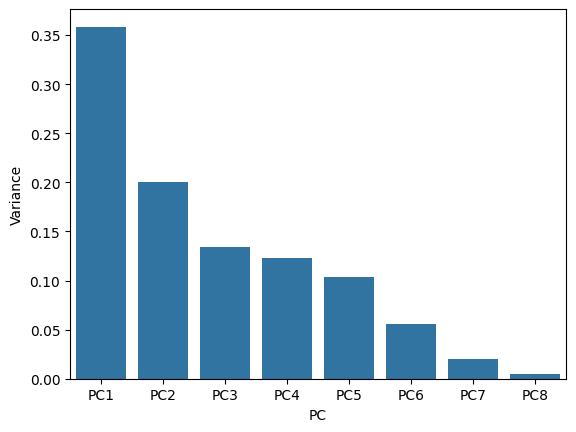

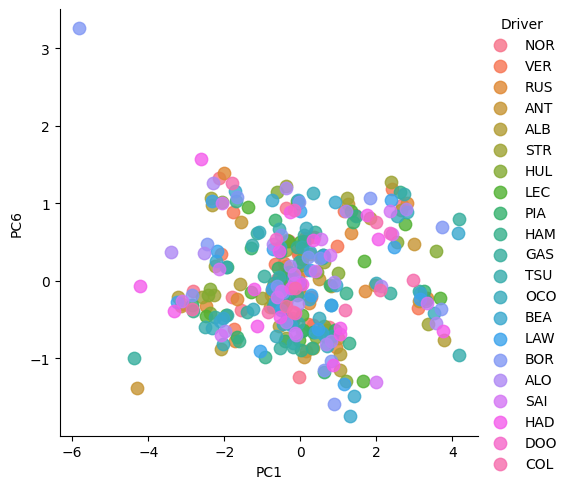

In [ ]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load dataset
features = ['Top Speed','Qualifying Time','AvgCornerSpeed','AvgCornerEntrySpeed','AvgCornerExitSpeed',
            'AvgStraightSpeed','AvgStraightEntrySpeed','AvgStraightExitSpeed']

X = df.loc[:, features].to_numpy() # Separating out the features
y = df.loc[:,['Driver']].to_numpy() # Separating out the target
X = StandardScaler().fit_transform(X) # Standardizing the features

def plot_pca(pca_df, component_num=8, pc_x=1, pc_y=2):
        pca = PCA(n_components=component_num)
        pc = pca.fit_transform(X)

        #2D table
        pc_cols = [f'PC{i+1}' for i in range(component_num)]
        pc_df = pd.DataFrame(data = pc , columns = pc_cols)
        pc_df['Driver'] = y.flatten()
        pc_df.head() #check

        print("Explained variance ratio (all PCs):",pca.explained_variance_ratio_)
        total_var = np.sum(pca.explained_variance_ratio_)
        print("Total variance (all PCs):", total_var)
        chosen_var = (pca.explained_variance_ratio_[pc_x-1] + 
                      pca.explained_variance_ratio_[pc_y-1])
        print(f"Variance explained by PC{pc_x} and PC{pc_y}: {chosen_var:.4f}")

        #Variance plot of all the PCs
        var_df = pd.DataFrame({
                'Variance':pca.explained_variance_ratio_,
                'PC':[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]})
        sns.barplot(x='PC',y="Variance", data=var_df);

        #PCA visualization
        pcx, pcy = f'PC{pc_x}', f'PC{pc_y}'
        g = sns.lmplot(x=pcx, y=pcy,
        data=pc_df, 
        fit_reg=False, 
        hue='Driver', # color by cluster
        legend=True,
        scatter_kws={"s": 80}) # specify the point size

plot_pca(df, component_num=8, pc_x=1, pc_y=6) #change pc_x and pc_y value to change PC view